In [1]:
# %matplotlib inline
%time from hikyuu.interactive import *

Initialize hikyuu_2.5.6_202504141509_RELEASE_macosx_arm64 ...
2025-04-17 23:58:04.016 [HKU-I] - current python version: 3.12.7 (main.cpp:66)


2025-04-17 23:58:04,490 [INFO] runing in interactive session [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:118) [hikyuu::hku_info]
2025-04-17 23:58:04,491 [INFO] running in jupyter [<module>] (/Users/fasiondog/workspace/hikyuu/hikyuu/__init__.py:125) [hikyuu::hku_info]


2025-04-17 23:58:04.492 [HKU-I] - Using MYSQL BaseInfoDriver (BaseInfoDriver.cpp:57)
2025-04-17 23:58:04.528 [HKU-I] - Loading market information... (StockManager.cpp:485)
2025-04-17 23:58:04.537 [HKU-I] - Loading stock type information... (StockManager.cpp:503)
2025-04-17 23:58:04.546 [HKU-I] - Loading stock information... (StockManager.cpp:405)
2025-04-17 23:58:04.679 [HKU-I] - Loading stock weight... (StockManager.cpp:521)
2025-04-17 23:58:05.568 [HKU-I] - Loading block... (StockManager.cpp:113)
2025-04-17 23:58:06.510 [HKU-I] - Loading KData... (StockManager.cpp:117)
2025-04-17 23:58:06.510 [HKU-I] - Preloading day kdata to buffer (max: 100000)! (StockManager.cpp:163)
2025-04-17 23:58:06.510 [HKU-I] - 2.00s Loaded Data. (StockManager.cpp:125)
CPU times: user 743 ms, sys: 135 ms, total: 877 ms
Wall time: 2.66 s


#  1 绘制指标

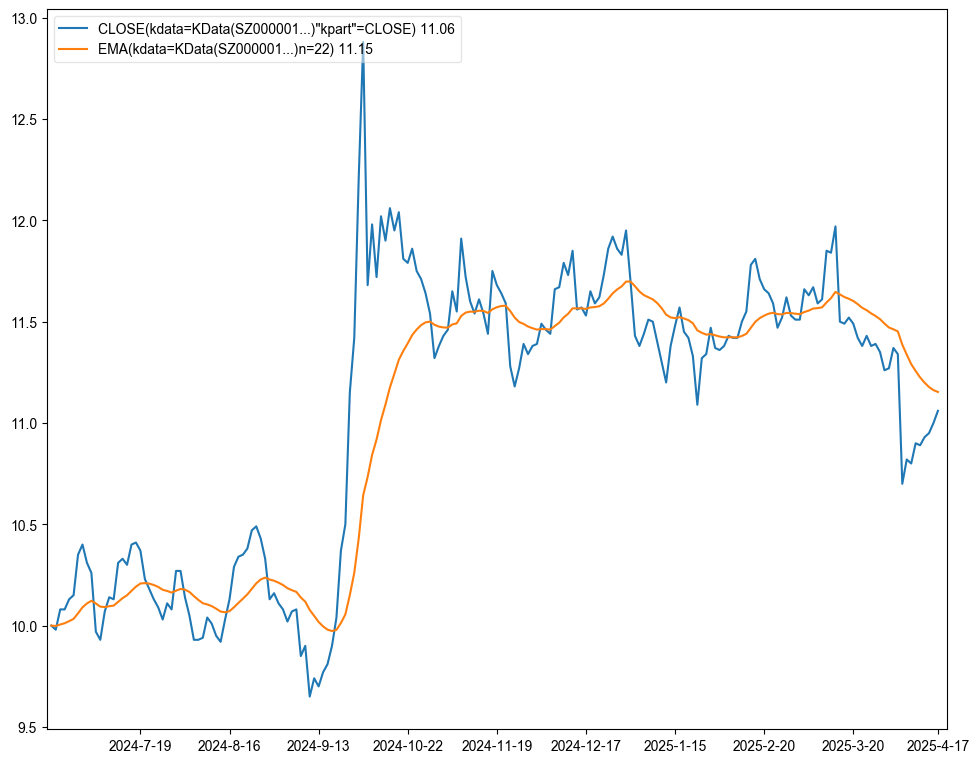

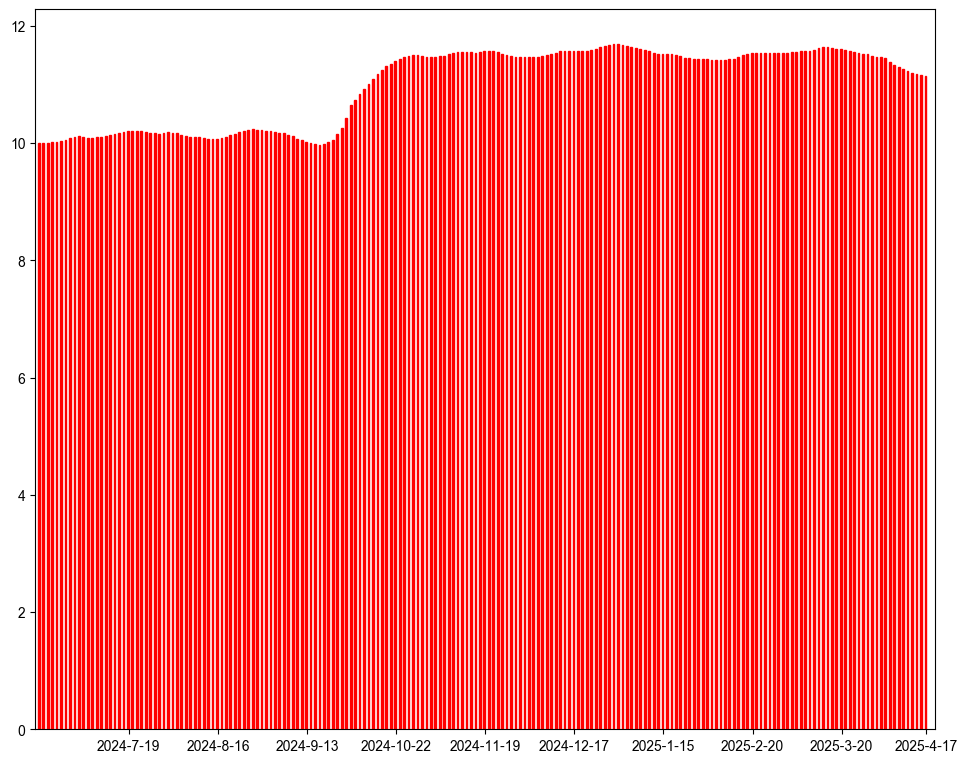

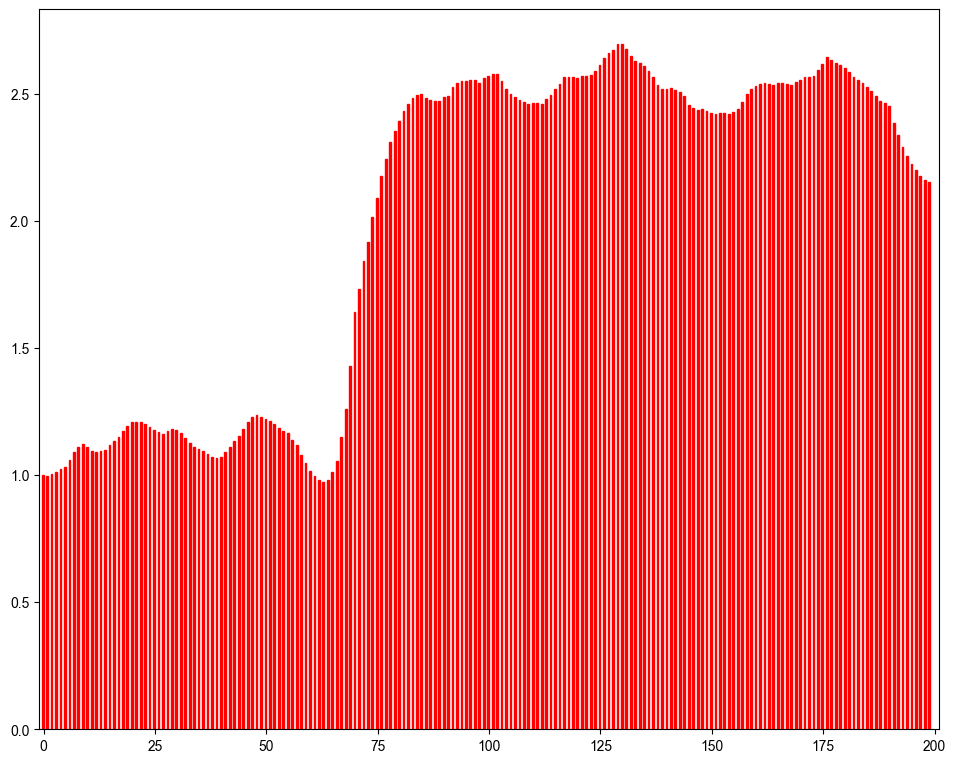

In [2]:
s = sm['sz000001']
k = s.get_kdata(Query(-200))


#抽取K线收盘价指标，一般指标计算参数只能是指标类型，所以必须先将K线数据生成指标类型
c = CLOSE(k)

#计算收盘价的EMA指标
a = EMA(c)

#绘制指标
c.plot(legend_on=True)
a.plot(new=False, legend_on=True)

#绘制柱状图
a.bar()

#修正下柱状图，使其更美观
PRICELIST([x-9 for x in a]).bar()

# 2 指标（Indicator）

在 Hikyuu 中，Indicator 的实例是用于计算的主要数据结构，一般 ind（如无说明，ind代表Indicator的实例）计算的参数为另一个ind，如EMA(x),x应是一个Indicator的实例。可以简单的理解为类似 numpy.array。

## 2.1 特殊的Indicator

其中存在一类特殊的Indicator，用于将K线数据或普通数组转换为ind，才能供其他ind进行计算，如 KDATA 将 KData 转化为一个ind。其他包括: OPEN,HIGH,LOW,CLOSE,AMO(成交金额),VOL(成交量),KDATA_PART。

In [3]:
print("k is a instance of KData:\n", k)
print("--------------------------\n")

kind = KDATA(k)
print("kind is a instance of Indicator:\n", kind)

k is a instance of KData:
 KData{
  size : 200
  stock: Stock(SZ, 000001, 平安银行, A股, 1, 1991-04-03 00:00:00, +infinity),
  query: KQuery(-200, 9223372036854775807, INDEX, DAY, NO_RECOVER)
}
--------------------------

kind is a instance of Indicator:
 Indicator{
  name: KDATA
  size: 200
  discard: 0
  result sets: 6
  params: params[kdata(KData): SZ000001, kpart(string): KDATA, ]
  support indicator param: False
  formula: KDATA
  values: [10.05, 9.97, 9.99, ..., 10.92, 10.93, 10.95]
}


In [4]:
#获取 ind 的结果集数量，如MACD通常返回3个结果集
r = kind.get_result_num()
print("result_num: ", r)

#获取第一个结果集
x = kind.get_result(0)
print(x)

result_num:  6
Indicator{
  name: IndicatorImp
  size: 200
  discard: 0
  result sets: 1
  params: params[kdata(KData): Null, ]
  support indicator param: False
  formula: IndicatorImp
  values: [10.05, 9.97, 9.99, ..., 10.92, 10.93, 10.95]
}


In [5]:
#以下效果相同
c1 = CLOSE(k)
c2 = KDATA_PART(k, 'close')

另外一个常用的特殊指标 PRICELIST将 Python 中的类 list 对象包装成ind。

In [6]:
x = PRICELIST([i for i in range(100)])
print(len(x), x)

100 Indicator{
  name: PRICELIST
  size: 100
  discard: 0
  result sets: 1
  params: params[data(PriceList): 100, discard(int): 0, kdata(KData): Null, result_index(int): 0, ]
  support indicator param: False
  formula: PRICELIST
  values: [0, 1, 2, ..., 97, 98, 99]
}


## 2.2 Indicator的特性与参数

每一个指标函数，如EMA、HHV，调用后生成一个ind对象，该对象本身可以再次调用生成新的ind。无论指标函数还是 ind 对象调用生成 ind，都是立刻进行计算。

In [7]:
e1 = EMA(CLOSE(k), n=5)
e2 = e1(CLOSE(k))
e3 = e2
print(e1 == e2)

Indicator{
  name: EQ
  size: 200
  discard: 0
  result sets: 1
  params: params[kdata(KData): Null, ]
  support indicator param: False
  formula: EMA(CLOSE) == EMA(CLOSE)
  values: [1, 1, 1, ..., 1, 1, 1]
}


除在指标函数中指定参数外，可以通过 getParam、setParam 方法来获取和修改 ind 对象的参数。修改参数后，ind 本身并不会发生变化，需要调用生成新的 ind，新的 ind 才是使用新参数计算的结果。

Indicator{
  name: EMA
  size: 200
  discard: 0
  result sets: 1
  params: params[kdata(KData): SZ000001, n(int): 22, ]
  support indicator param: True
  ind params: {}
  formula: EMA(CLOSE)
  values: [10, 9.99826, 10.0054, ..., 11.1774, 11.162, 11.1531]
}
22


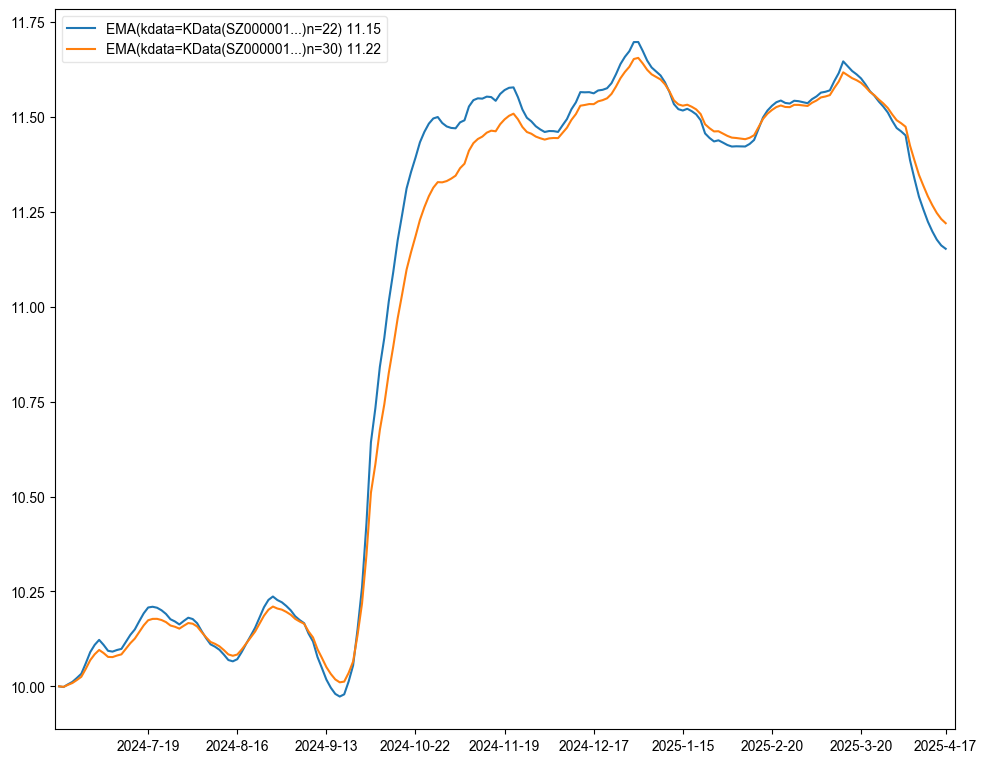

In [8]:
e = EMA(c)
print(e)
print(e.get_param('n'))
e.plot(legend_on=True)

e.set_param('n', 30)
e = e(c)
e.plot(new=False, legend_on=True)

查看 ind 参数。ind 参数支持：

- i : int
- s : str
- b : bool
- d : float

In [9]:
#EMA指标有参数 "n"，类型"i"代表整数
print(EMA())

Indicator{
  name: EMA
  size: 0
  discard: 0
  result sets: 1
  params: params[kdata(KData): Null, n(int): 22, ]
  support indicator param: True
  ind params: {}
  formula: EMA
}


## 2.3 TA-Lib包装指标

在交互工具里对TA-Lib进行了包装，命名方式统一为 TA_FUNC名称。其中，ta-lib指标的lookback属性，用discard属性代替。

Indicator{
  name: TA_SMA
  size: 200
  discard: 29
  result sets: 1
  params: params[kdata(KData): SZ000001, n(int): 30, ]
  support indicator param: True
  ind params: {}
  formula: TA_SMA(CLOSE)
  values: [nan, nan, nan, ..., 11.3637, 11.3467, 11.3267]
}
29


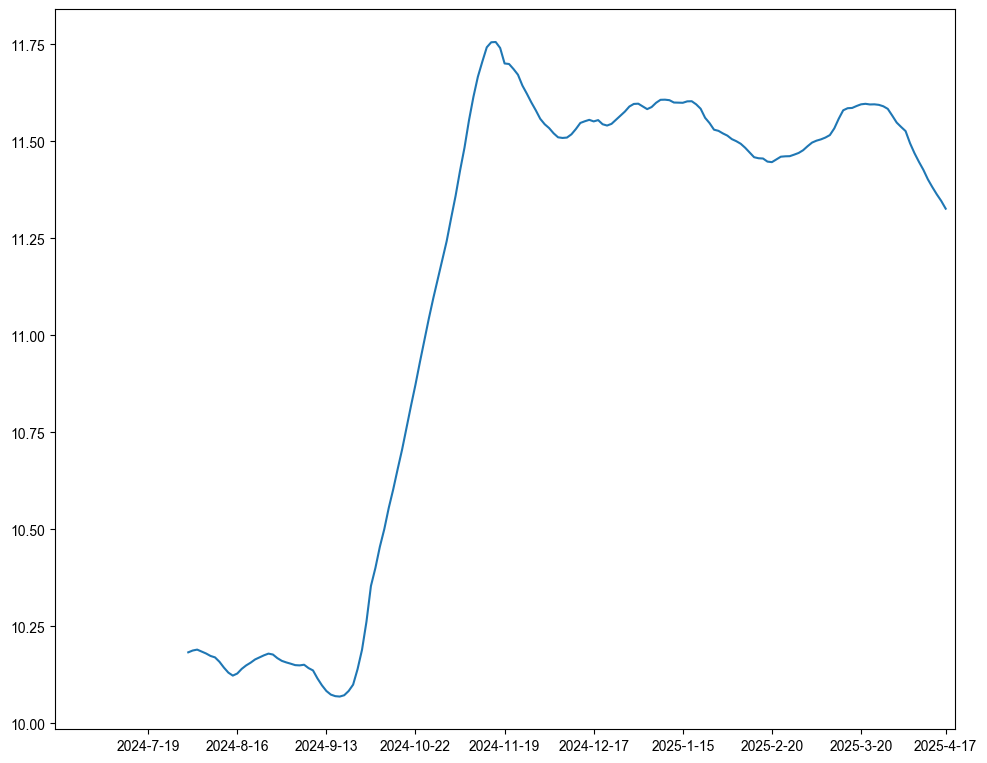

In [10]:
x = TA_SMA(CLOSE(k))
print(x)
x.plot()

print(x.discard)

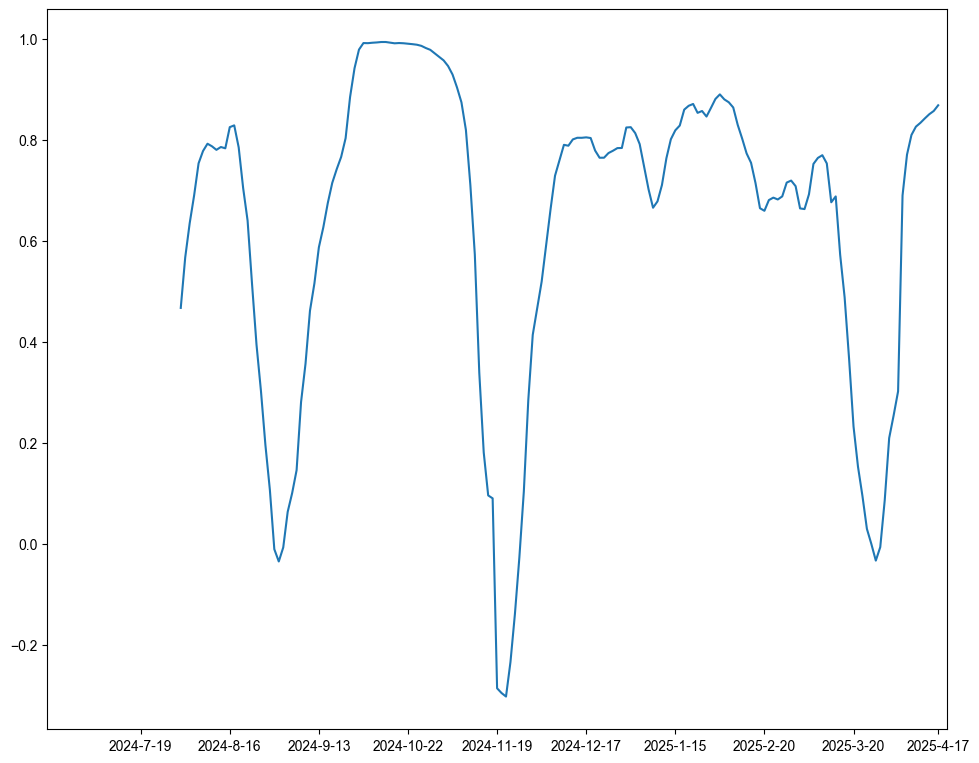

In [12]:
query = Query(-200)
k1 = sm['sh000001'].get_kdata(query)
k2 = sm['sz000001'].get_kdata(query)

cr = TA_CORREL(CLOSE(k1), CLOSE(k2))
cr.plot()

## 2.4 动态指标参数

在通道信等证券行情软件中，其技术指标中的窗口参数通常支持整数，也支持使用指标，如：

```
T1:=HHVBARS(H,120); {120内的最高点距今天的天数}
L120:=LLV(L,T1+1); {120内的最高点至今，这个区间的最低点}
```

***自 1.2.3 版本后，Hikyuu 也开始支持使用指标作为窗口参数***

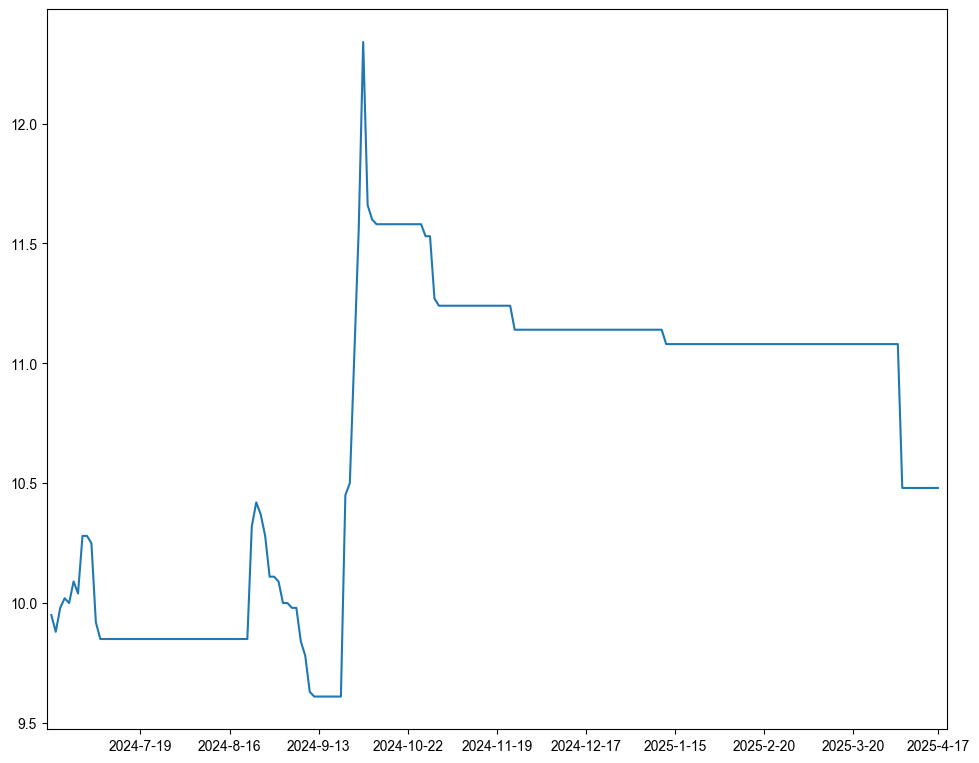

In [13]:
h = HIGH(k)
l = LOW(k)
T1 = HHVBARS(h, 120)
L120 = LLV(l, T1+1)
L120.plot()

**注意事项**

由于无法区分 Indicator(ind) 形式时，ind 究竟是指标参数还是待计算的输出数据，此时如果希望 ind 作为参数，需要通过 IndParam 进行显示指定，如：EMA(IndParam(ind))。

最佳的方式，则是通过指定参数名，来明确说明使用的是参数：

```
x = EMA(c)  # 以收盘价作为计算的输入
y = EMA(IndParam(c)) # 以收盘价作为 n 参数
z = EMA(n=c) # 以收盘价作为参数 n
```

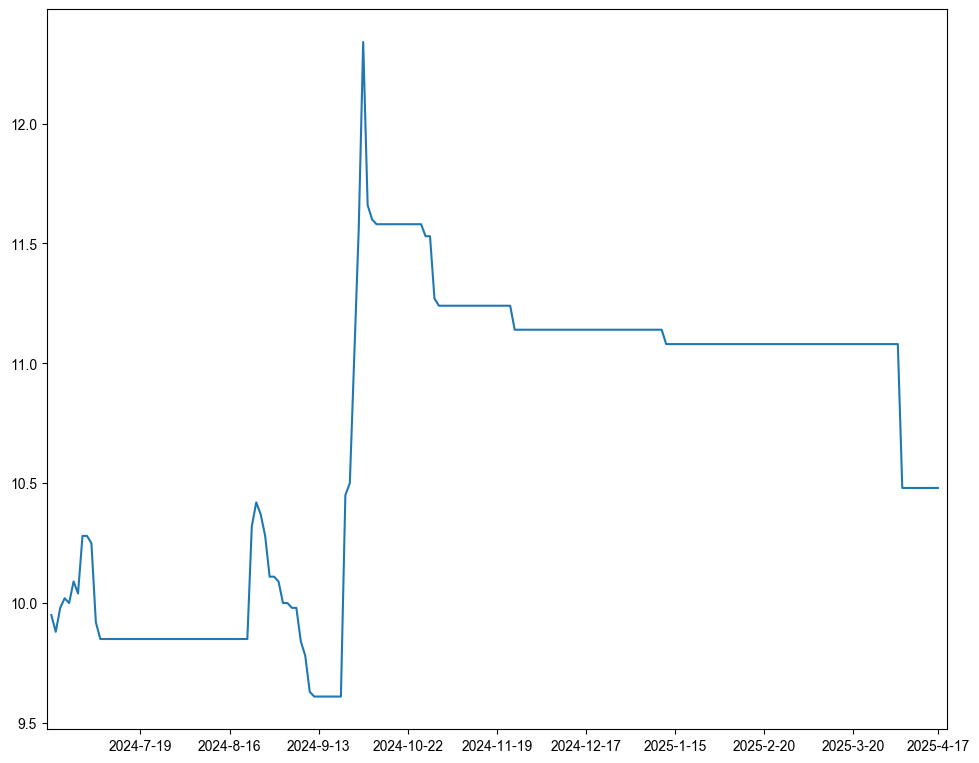

In [14]:
# 或者以原型的方式，通过指定上下文计算
T1 = HHVBARS(H, 120)
L120 = LLV(L, T1+1)
L120.set_context(k)
L120.plot()